In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
n_layers = 5
input_size = 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha) #Normalization

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta) #Normalization
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h) #Normalization

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cl values

In [25]:
cl = target_c3.reshape((-1,1))

In [26]:
y = (cl-np.min(cl))/(np.max(cl)-np.min(cl))

In [27]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test, cd_train, cd_val, cd_test = dataset_split(x, y, cl,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [29]:
x_train.shape

(100, 113)

In [30]:
y_train.shape

(100, 1)

In [31]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3+total_coords.shape[1])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer)(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [32]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 1)                 129   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221230\\steady_previousSetting"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 1s 73ms/step - loss: 0.0880 - rmse: 0.2967 - val_loss: 0.0417 - val_rmse: 0.2042 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0418 - rmse: 0.2043 - val_loss: 0.0333 - val_rmse: 0.1825 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0296 - rmse: 0.1722 - val_loss: 0.0221 - val_rmse: 0.1487 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0115 - val_rmse: 0.1073 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0130 - rmse: 0.1142 - val_loss: 0.0089 - val_rmse: 0.0943 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0127 - rmse: 0.1129 - val_loss: 0.0048 - val_rmse: 0.0694 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0093 - rmse: 0.0967 - val_loss: 0.0035 - va

Epoch 57/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0013 - rmse: 0.0360 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 0.0010
Epoch 58/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0017 - rmse: 0.0414 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 0.0010
Epoch 59/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.9504e-04 - rmse: 0.0299 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 0.0010
Epoch 60/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0044 - val_rmse: 0.0664 - lr: 0.0010
Epoch 61/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0016 - rmse: 0.0403 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 0.0010
Epoch 62/10000
5/5 [==============================] - 0s 9ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0034 - val_rmse: 0.0582 - lr: 0.0010
Epoch 63/10000
5/5 [==============================] - 0s 10ms/step - loss: 0.0020 - rmse: 0.0451 - val_loss: 9.946

5/5 [==============================] - 0s 10ms/step - loss: 2.8888e-04 - rmse: 0.0170 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 0.0010
Epoch 112/10000
5/5 [==============================] - 0s 9ms/step - loss: 2.7252e-04 - rmse: 0.0165 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 0.0010
Epoch 113/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.3760e-04 - rmse: 0.0117 - val_loss: 0.0012 - val_rmse: 0.0350 - lr: 0.0010
Epoch 114/10000
5/5 [==============================] - 0s 9ms/step - loss: 9.1037e-05 - rmse: 0.0095 - val_loss: 7.1220e-04 - val_rmse: 0.0267 - lr: 0.0010
Epoch 115/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.8345e-05 - rmse: 0.0094 - val_loss: 0.0015 - val_rmse: 0.0387 - lr: 0.0010
Epoch 116/10000
5/5 [==============================] - 0s 10ms/step - loss: 1.0752e-04 - rmse: 0.0104 - val_loss: 0.0010 - val_rmse: 0.0320 - lr: 0.0010
Epoch 117/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.7347e-05 - rmse: 0.

5/5 [==============================] - 0s 11ms/step - loss: 5.0467e-06 - rmse: 0.0022 - val_loss: 7.1732e-04 - val_rmse: 0.0268 - lr: 0.0010
Epoch 164/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.9374e-06 - rmse: 0.0026 - val_loss: 8.0489e-04 - val_rmse: 0.0284 - lr: 0.0010
Epoch 165/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.5855e-06 - rmse: 0.0024 - val_loss: 6.4773e-04 - val_rmse: 0.0255 - lr: 0.0010
Epoch 166/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.9837e-06 - rmse: 0.0022 - val_loss: 6.7769e-04 - val_rmse: 0.0260 - lr: 0.0010
Epoch 167/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.8998e-06 - rmse: 0.0020 - val_loss: 7.1260e-04 - val_rmse: 0.0267 - lr: 0.0010
Epoch 168/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.0491e-06 - rmse: 0.0020 - val_loss: 6.1806e-04 - val_rmse: 0.0249 - lr: 0.0010
Epoch 169/10000
5/5 [==============================] - 0s 11ms/step - loss

5/5 [==============================] - 0s 11ms/step - loss: 1.8304e-06 - rmse: 0.0014 - val_loss: 6.1497e-04 - val_rmse: 0.0248 - lr: 0.0010
Epoch 216/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.4302e-06 - rmse: 0.0012 - val_loss: 6.6559e-04 - val_rmse: 0.0258 - lr: 0.0010
Epoch 217/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7493e-06 - rmse: 0.0013 - val_loss: 6.3598e-04 - val_rmse: 0.0252 - lr: 0.0010
Epoch 218/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.9920e-06 - rmse: 0.0017 - val_loss: 6.3047e-04 - val_rmse: 0.0251 - lr: 0.0010
Epoch 219/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9663e-06 - rmse: 0.0020 - val_loss: 6.1013e-04 - val_rmse: 0.0247 - lr: 0.0010
Epoch 220/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.0223e-06 - rmse: 0.0014 - val_loss: 6.7185e-04 - val_rmse: 0.0259 - lr: 0.0010
Epoch 221/10000
5/5 [==============================] - 0s 11ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 1.4054e-04 - rmse: 0.0119 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 0.0010
Epoch 268/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.5145e-05 - rmse: 0.0098 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 0.0010
Epoch 269/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1371e-04 - rmse: 0.0146 - val_loss: 0.0015 - val_rmse: 0.0390 - lr: 0.0010
Epoch 270/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4007e-04 - rmse: 0.0155 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 0.0010
Epoch 271/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.5588e-04 - rmse: 0.0189 - val_loss: 0.0025 - val_rmse: 0.0499 - lr: 0.0010
Epoch 272/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.4880e-04 - rmse: 0.0274 - val_loss: 0.0020 - val_rmse: 0.0448 - lr: 0.0010
Epoch 273/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.0131e-04 - rmse: 0.0

Epoch 320/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.1970e-06 - rmse: 0.0018 - val_loss: 3.9962e-04 - val_rmse: 0.0200 - lr: 0.0010
Epoch 321/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.5425e-06 - rmse: 0.0016 - val_loss: 3.0021e-04 - val_rmse: 0.0173 - lr: 0.0010
Epoch 322/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.6188e-06 - rmse: 0.0016 - val_loss: 3.9907e-04 - val_rmse: 0.0200 - lr: 0.0010
Epoch 323/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.1837e-06 - rmse: 0.0018 - val_loss: 3.7708e-04 - val_rmse: 0.0194 - lr: 0.0010
Epoch 324/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2318e-06 - rmse: 0.0015 - val_loss: 3.3062e-04 - val_rmse: 0.0182 - lr: 0.0010
Epoch 325/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.6528e-06 - rmse: 0.0016 - val_loss: 3.9815e-04 - val_rmse: 0.0200 - lr: 0.0010
Epoch 326/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 11ms/step - loss: 6.0944e-05 - rmse: 0.0078 - val_loss: 4.9694e-04 - val_rmse: 0.0223 - lr: 0.0010
Epoch 373/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.7670e-05 - rmse: 0.0076 - val_loss: 8.5356e-04 - val_rmse: 0.0292 - lr: 0.0010
Epoch 374/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.0187e-05 - rmse: 0.0078 - val_loss: 3.0683e-04 - val_rmse: 0.0175 - lr: 0.0010
Epoch 375/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.1936e-05 - rmse: 0.0085 - val_loss: 3.7165e-04 - val_rmse: 0.0193 - lr: 0.0010
Epoch 376/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.8273e-05 - rmse: 0.0076 - val_loss: 0.0011 - val_rmse: 0.0332 - lr: 0.0010
Epoch 377/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.9591e-05 - rmse: 0.0095 - val_loss: 1.9024e-04 - val_rmse: 0.0138 - lr: 0.0010
Epoch 378/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.

5/5 [==============================] - 0s 11ms/step - loss: 7.2368e-05 - rmse: 0.0085 - val_loss: 2.5685e-04 - val_rmse: 0.0160 - lr: 0.0010
Epoch 425/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.0730e-05 - rmse: 0.0071 - val_loss: 6.5662e-04 - val_rmse: 0.0256 - lr: 0.0010
Epoch 426/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.8134e-05 - rmse: 0.0076 - val_loss: 1.3913e-04 - val_rmse: 0.0118 - lr: 0.0010
Epoch 427/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9779e-05 - rmse: 0.0063 - val_loss: 4.6673e-04 - val_rmse: 0.0216 - lr: 0.0010
Epoch 428/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.4185e-05 - rmse: 0.0058 - val_loss: 7.2257e-04 - val_rmse: 0.0269 - lr: 0.0010
Epoch 429/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.4190e-05 - rmse: 0.0049 - val_loss: 4.6734e-04 - val_rmse: 0.0216 - lr: 0.0010
Epoch 430/10000
5/5 [==============================] - 0s 12ms/step - loss

Epoch 478/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.1933e-04 - rmse: 0.0179 - val_loss: 0.0012 - val_rmse: 0.0351 - lr: 0.0010
Epoch 479/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.0362e-04 - rmse: 0.0143 - val_loss: 9.2423e-04 - val_rmse: 0.0304 - lr: 0.0010
Epoch 480/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.4747e-04 - rmse: 0.0121 - val_loss: 9.3777e-04 - val_rmse: 0.0306 - lr: 0.0010
Epoch 481/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.4659e-05 - rmse: 0.0086 - val_loss: 8.0175e-04 - val_rmse: 0.0283 - lr: 0.0010
Epoch 482/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.7900e-05 - rmse: 0.0099 - val_loss: 7.0508e-04 - val_rmse: 0.0266 - lr: 0.0010
Epoch 483/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.0923e-05 - rmse: 0.0078 - val_loss: 5.5483e-04 - val_rmse: 0.0236 - lr: 0.0010
Epoch 484/10000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 12ms/step - loss: 3.9425e-06 - rmse: 0.0020 - val_loss: 6.6076e-04 - val_rmse: 0.0257 - lr: 0.0010
Epoch 531/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.1864e-06 - rmse: 0.0018 - val_loss: 6.3008e-04 - val_rmse: 0.0251 - lr: 0.0010
Epoch 532/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.8045e-06 - rmse: 0.0020 - val_loss: 8.0141e-04 - val_rmse: 0.0283 - lr: 0.0010
Epoch 533/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.8184e-06 - rmse: 0.0022 - val_loss: 7.8115e-04 - val_rmse: 0.0279 - lr: 0.0010
Epoch 534/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.6118e-06 - rmse: 0.0024 - val_loss: 7.0366e-04 - val_rmse: 0.0265 - lr: 0.0010
Epoch 535/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.1053e-06 - rmse: 0.0018 - val_loss: 6.9455e-04 - val_rmse: 0.0264 - lr: 0.0010
Epoch 536/10000
5/5 [==============================] - 0s 11ms/step - loss

Epoch 582/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.1101e-07 - rmse: 7.8167e-04 - val_loss: 7.3775e-04 - val_rmse: 0.0272 - lr: 0.0010
Epoch 583/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.8140e-07 - rmse: 6.9383e-04 - val_loss: 7.3837e-04 - val_rmse: 0.0272 - lr: 0.0010
Epoch 584/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.4007e-07 - rmse: 7.3489e-04 - val_loss: 7.4746e-04 - val_rmse: 0.0273 - lr: 0.0010
Epoch 585/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.7902e-07 - rmse: 6.9211e-04 - val_loss: 7.4216e-04 - val_rmse: 0.0272 - lr: 0.0010
Epoch 586/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.6358e-07 - rmse: 6.8086e-04 - val_loss: 7.3412e-04 - val_rmse: 0.0271 - lr: 0.0010
Epoch 587/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.7283e-07 - rmse: 6.8763e-04 - val_loss: 7.4103e-04 - val_rmse: 0.0272 - lr: 0.0010
Epoch 588/10000
5/5 [=============

Epoch 632/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.0843e-07 - rmse: 4.5654e-04 - val_loss: 7.4129e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 633/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.0237e-07 - rmse: 4.4985e-04 - val_loss: 7.3780e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 634/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.8500e-07 - rmse: 4.3011e-04 - val_loss: 7.4364e-04 - val_rmse: 0.0273 - lr: 5.0000e-04
Epoch 635/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7756e-07 - rmse: 4.2138e-04 - val_loss: 7.4006e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 636/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7310e-07 - rmse: 4.1605e-04 - val_loss: 7.3968e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 637/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.8714e-07 - rmse: 4.3259e-04 - val_loss: 7.4169e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 638/

Epoch 682/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.1097e-07 - rmse: 3.3313e-04 - val_loss: 7.4058e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 683/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.1321e-07 - rmse: 3.3646e-04 - val_loss: 7.3848e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 684/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.2315e-07 - rmse: 3.5092e-04 - val_loss: 7.4147e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 685/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0658e-07 - rmse: 3.2646e-04 - val_loss: 7.3801e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 686/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.1067e-07 - rmse: 3.3266e-04 - val_loss: 7.3686e-04 - val_rmse: 0.0271 - lr: 5.0000e-04
Epoch 687/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0813e-07 - rmse: 3.2884e-04 - val_loss: 7.3947e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 688/

Epoch 732/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.2766e-08 - rmse: 2.8769e-04 - val_loss: 7.3878e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 733/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.8258e-08 - rmse: 2.7975e-04 - val_loss: 7.4132e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 734/10000
5/5 [==============================] - 0s 11ms/step - loss: 8.5888e-08 - rmse: 2.9307e-04 - val_loss: 7.4444e-04 - val_rmse: 0.0273 - lr: 5.0000e-04
Epoch 735/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.8323e-08 - rmse: 2.7986e-04 - val_loss: 7.3904e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 736/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.1793e-08 - rmse: 2.6794e-04 - val_loss: 7.3491e-04 - val_rmse: 0.0271 - lr: 5.0000e-04
Epoch 737/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.3306e-08 - rmse: 2.7075e-04 - val_loss: 7.3850e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 738/

Epoch 782/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.7896e-08 - rmse: 2.1885e-04 - val_loss: 7.3381e-04 - val_rmse: 0.0271 - lr: 5.0000e-04
Epoch 783/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.0609e-08 - rmse: 2.2496e-04 - val_loss: 7.3948e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 784/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.1967e-08 - rmse: 2.4893e-04 - val_loss: 7.4189e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 785/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.4206e-08 - rmse: 2.3282e-04 - val_loss: 7.3206e-04 - val_rmse: 0.0271 - lr: 5.0000e-04
Epoch 786/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.5797e-08 - rmse: 2.3621e-04 - val_loss: 7.3751e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 787/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.7120e-08 - rmse: 2.1707e-04 - val_loss: 7.3792e-04 - val_rmse: 0.0272 - lr: 5.0000e-04
Epoch 788/

Epoch 831/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.6677e-08 - rmse: 1.9151e-04 - val_loss: 7.3888e-04 - val_rmse: 0.0272 - lr: 2.5000e-04
Epoch 832/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2651e-08 - rmse: 1.8070e-04 - val_loss: 7.3691e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 833/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.2788e-08 - rmse: 1.8108e-04 - val_loss: 7.3342e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 834/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.2825e-08 - rmse: 1.8118e-04 - val_loss: 7.4067e-04 - val_rmse: 0.0272 - lr: 2.5000e-04
Epoch 835/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5969e-08 - rmse: 1.8966e-04 - val_loss: 7.3874e-04 - val_rmse: 0.0272 - lr: 2.5000e-04
Epoch 836/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.7230e-08 - rmse: 1.9295e-04 - val_loss: 7.3016e-04 - val_rmse: 0.0270 - lr: 2.5000e-04
Epoch 837/

Epoch 881/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4044e-08 - rmse: 1.5506e-04 - val_loss: 7.3497e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 882/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4138e-08 - rmse: 1.5536e-04 - val_loss: 7.3373e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 883/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5747e-08 - rmse: 1.6046e-04 - val_loss: 7.3867e-04 - val_rmse: 0.0272 - lr: 2.5000e-04
Epoch 884/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4276e-08 - rmse: 1.5581e-04 - val_loss: 7.3681e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 885/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4638e-08 - rmse: 1.5696e-04 - val_loss: 7.3578e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 886/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.6036e-08 - rmse: 1.6136e-04 - val_loss: 7.3636e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 887/

Epoch 931/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.6670e-08 - rmse: 1.6331e-04 - val_loss: 7.3293e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 932/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0574e-08 - rmse: 1.4344e-04 - val_loss: 7.4015e-04 - val_rmse: 0.0272 - lr: 2.5000e-04
Epoch 933/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3637e-08 - rmse: 1.5374e-04 - val_loss: 7.3368e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 934/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0825e-08 - rmse: 1.4431e-04 - val_loss: 7.3422e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 935/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0165e-08 - rmse: 1.4200e-04 - val_loss: 7.3575e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 936/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1300e-08 - rmse: 1.4595e-04 - val_loss: 7.3313e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 937/

Epoch 981/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0599e-08 - rmse: 1.4352e-04 - val_loss: 7.3508e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 982/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0480e-08 - rmse: 1.4311e-04 - val_loss: 7.3156e-04 - val_rmse: 0.0270 - lr: 2.5000e-04
Epoch 983/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.6718e-08 - rmse: 1.2930e-04 - val_loss: 7.3417e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 984/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.7409e-08 - rmse: 1.3194e-04 - val_loss: 7.3580e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 985/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.8612e-08 - rmse: 1.3642e-04 - val_loss: 7.3215e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 986/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.7892e-08 - rmse: 1.3376e-04 - val_loss: 7.3334e-04 - val_rmse: 0.0271 - lr: 2.5000e-04
Epoch 987/

5/5 [==============================] - 0s 12ms/step - loss: 1.2980e-08 - rmse: 1.1393e-04 - val_loss: 7.3058e-04 - val_rmse: 0.0270 - lr: 1.2500e-04
Epoch 1030/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3103e-08 - rmse: 1.1447e-04 - val_loss: 7.3452e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1031/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1658e-08 - rmse: 1.0797e-04 - val_loss: 7.3339e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1032/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1625e-08 - rmse: 1.0782e-04 - val_loss: 7.3323e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1033/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0619e-08 - rmse: 1.0305e-04 - val_loss: 7.3197e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1034/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1867e-08 - rmse: 1.0894e-04 - val_loss: 7.3422e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1035/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 1.7643e-08 - rmse: 1.3283e-04 - val_loss: 7.2774e-04 - val_rmse: 0.0270 - lr: 1.2500e-04
Epoch 1079/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.2021e-08 - rmse: 1.0964e-04 - val_loss: 7.3246e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1080/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1742e-08 - rmse: 1.0836e-04 - val_loss: 7.3632e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1081/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1628e-08 - rmse: 1.0783e-04 - val_loss: 7.2944e-04 - val_rmse: 0.0270 - lr: 1.2500e-04
Epoch 1082/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1667e-08 - rmse: 1.0802e-04 - val_loss: 7.3232e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1083/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3644e-08 - rmse: 1.1681e-04 - val_loss: 7.3580e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1084/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 1.0379e-08 - rmse: 1.0188e-04 - val_loss: 7.3193e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1128/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.4645e-09 - rmse: 9.2003e-05 - val_loss: 7.3229e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1129/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.5625e-09 - rmse: 9.2534e-05 - val_loss: 7.3226e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1130/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.5412e-09 - rmse: 9.2418e-05 - val_loss: 7.3502e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1131/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0486e-08 - rmse: 1.0240e-04 - val_loss: 7.3635e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1132/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1173e-08 - rmse: 1.0570e-04 - val_loss: 7.3265e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1133/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 9.4328e-09 - rmse: 9.7122e-05 - val_loss: 7.3697e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1177/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0061e-08 - rmse: 1.0030e-04 - val_loss: 7.3370e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1178/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0540e-08 - rmse: 1.0266e-04 - val_loss: 7.3112e-04 - val_rmse: 0.0270 - lr: 1.2500e-04
Epoch 1179/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.5775e-08 - rmse: 1.2560e-04 - val_loss: 7.3227e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1180/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.6928e-09 - rmse: 9.8452e-05 - val_loss: 7.3523e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1181/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.6554e-09 - rmse: 9.8262e-05 - val_loss: 7.3175e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1182/10000
5/5 

5/5 [==============================] - 0s 11ms/step - loss: 6.4127e-09 - rmse: 8.0079e-05 - val_loss: 7.3363e-04 - val_rmse: 0.0271 - lr: 1.2500e-04
Epoch 1226/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2308e-08 - rmse: 1.1094e-04
Epoch 1226: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
5/5 [==============================] - 0s 12ms/step - loss: 6.1778e-09 - rmse: 7.8599e-05 - val_loss: 7.3039e-04 - val_rmse: 0.0270 - lr: 1.2500e-04
Epoch 1227/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.1425e-09 - rmse: 7.8374e-05 - val_loss: 7.3278e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1228/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.9435e-09 - rmse: 7.7094e-05 - val_loss: 7.3384e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1229/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.2949e-09 - rmse: 7.9340e-05 - val_loss: 7.3264e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1230/10000
5/5 [==

5/5 [==============================] - 0s 12ms/step - loss: 5.6962e-09 - rmse: 7.5473e-05 - val_loss: 7.3131e-04 - val_rmse: 0.0270 - lr: 6.2500e-05
Epoch 1274/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.7702e-09 - rmse: 7.5962e-05 - val_loss: 7.3314e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1275/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.0007e-09 - rmse: 7.0715e-05 - val_loss: 7.3159e-04 - val_rmse: 0.0270 - lr: 6.2500e-05
Epoch 1276/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.1557e-09 - rmse: 7.1803e-05 - val_loss: 7.3212e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1277/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.7453e-09 - rmse: 6.8886e-05 - val_loss: 7.3332e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1278/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.0585e-09 - rmse: 7.1123e-05 - val_loss: 7.3237e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1279/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.9023e-09 - rmse: 6.2468e-05 - val_loss: 7.3252e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1323/10000
5/5 [==============================] - 0s 13ms/step - loss: 4.2071e-09 - rmse: 6.4862e-05 - val_loss: 7.3276e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1324/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.2947e-09 - rmse: 6.5534e-05 - val_loss: 7.3237e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1325/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.6863e-09 - rmse: 6.8457e-05 - val_loss: 7.3187e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1326/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.6835e-09 - rmse: 6.8436e-05 - val_loss: 7.3305e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1327/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.5887e-09 - rmse: 6.7740e-05 - val_loss: 7.3161e-04 - val_rmse: 0.0270 - lr: 6.2500e-05
Epoch 1328/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.7771e-09 - rmse: 6.1458e-05 - val_loss: 7.3224e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1372/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.7248e-09 - rmse: 6.1031e-05 - val_loss: 7.3192e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1373/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.9350e-09 - rmse: 6.2730e-05 - val_loss: 7.3215e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1374/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5146e-09 - rmse: 5.9284e-05 - val_loss: 7.3222e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1375/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5701e-09 - rmse: 5.9750e-05 - val_loss: 7.3232e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1376/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5873e-09 - rmse: 5.9894e-05 - val_loss: 7.3220e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1377/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.6072e-09 - rmse: 6.0060e-05 - val_loss: 7.3299e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1421/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.3217e-09 - rmse: 5.7634e-05 - val_loss: 7.3225e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1422/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.8534e-09 - rmse: 6.2076e-05 - val_loss: 7.3269e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1423/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.9960e-09 - rmse: 5.4736e-05 - val_loss: 7.3211e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1424/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.6101e-09 - rmse: 6.0084e-05 - val_loss: 7.3207e-04 - val_rmse: 0.0271 - lr: 6.2500e-05
Epoch 1425/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9210e-09 - rmse: 6.2618e-05 - val_loss: 7.3134e-04 - val_rmse: 0.0270 - lr: 6.2500e-05
Epoch 1426/10000
1/5 

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:18.964694


In [39]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Steady_previousSetting\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CdPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

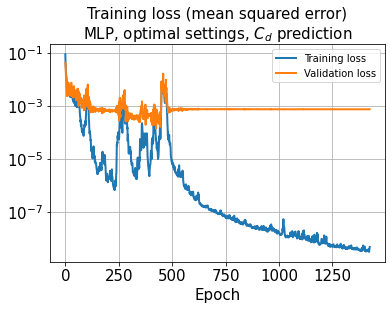

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_d$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

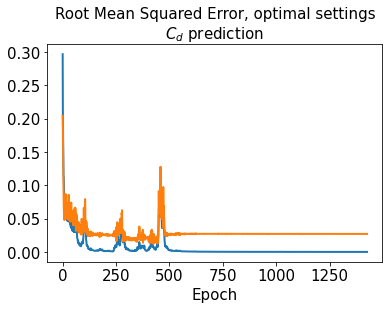

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_d$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

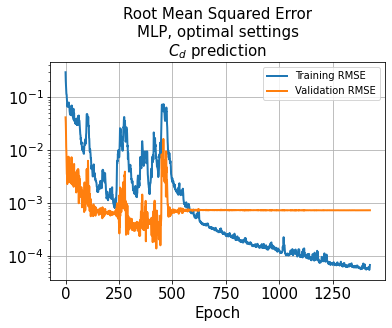

In [42]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_d$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 5.7764e-05 - rmse: 0.0076


In [44]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 21ms/step - loss: 8.7857e-04 - rmse: 0.0296


In [45]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230steady_MLP_previousSetting_test"+str(test_rate)+ "_" + str(n_units) +"units_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [47]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [48]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cl)-np.min(cl))+np.min(cl)

In [49]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [50]:
index_train = define_index(cl, y_train)
index_val = define_index(cl, y_val)
index_test = define_index(cl, y_test)

In [51]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [52]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [53]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.021383350213520988
1.019827035773306


In [54]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.03239062441149596
1.616036698132689


In [55]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.08335631972550585
2.444437615504384


In [56]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [57]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [58]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [59]:
os.chdir(storage_dir)

In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [63]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [64]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [65]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [66]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, steady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_l$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

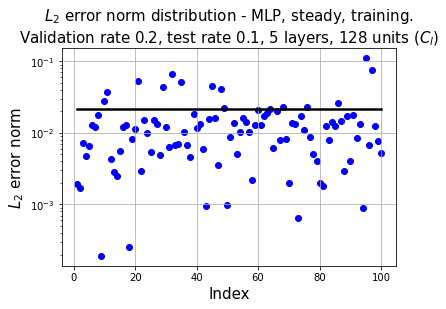

In [67]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

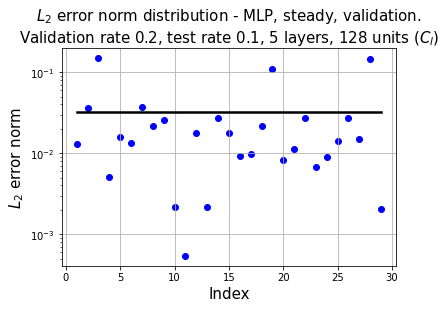

In [68]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

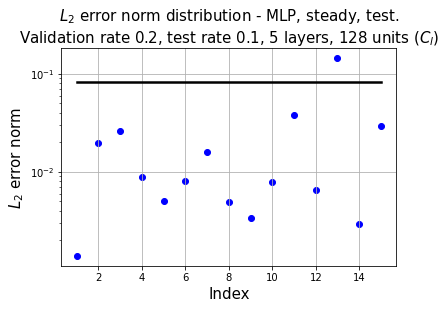

In [69]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [70]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [71]:
l2_error(predicted, y)

0.035296336366447405

In [72]:
l2_error(denormalize(predicted), denormalize(y))

0.02626880831833892

In [73]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [74]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [75]:
iTrain

array([[0.0350164 ],
       [0.04483905],
       [0.09596356],
       [0.13957671],
       [0.19785953],
       [0.27611924],
       [0.03886851],
       [0.07159703],
       [0.21020516],
       [0.2915698 ],
       [0.4150698 ],
       [0.64125264],
       [0.05469708],
       [0.07753994],
       [0.11257447],
       [0.22118364],
       [0.43219877],
       [0.04524316],
       [0.08152889],
       [0.11659801],
       [0.16412462],
       [0.22686327],
       [0.31228406],
       [0.44079519],
       [0.68572263],
       [0.04646518],
       [0.05910052],
       [0.08252035],
       [0.11716459],
       [0.16439454],
       [0.44134144],
       [0.0297905 ],
       [0.05647187],
       [0.08107892],
       [0.16652834],
       [0.23226425],
       [0.32011826],
       [0.70817576],
       [0.05428303],
       [0.07070173],
       [0.13714636],
       [0.18919921],
       [0.25937006],
       [0.35224837],
       [0.49503998],
       [0.77000573],
       [0.06659042],
       [0.084

In [76]:
aa = aa*16

In [77]:
aa = np.ceil(aa)

In [78]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain, iVal, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_d$ prediction (normalized), L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, beta=%d\nCd prediction (normalized), L2 error=%.4f'%(h[i], beta[i], l2_error_Cl)
    
    if i==0:
        title_Cd = title_0_Cl
        savename1 =  "CdComparison_NACA0018.jpg"
    else:
        title_Cd = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    # CD graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$ (normalized)')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
'''
    # CL graph plot
    plt.plot(alpha, denormalize(CL), 'k-', label='Ground truth')
    plt.plot(alpha, denormalize(cl), 'k--', label='Predicted value')
    plt.scatter(aTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(aVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(aTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$ (normalized)')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

"\n    # CL graph plot\n    plt.plot(alpha, denormalize(CL), 'k-', label='Ground truth')\n    plt.plot(alpha, denormalize(cl), 'k--', label='Predicted value')\n    plt.scatter(aTrain, denormalize(iTrain), color='b', label='Training set')\n    plt.scatter(aVal, denormalize(iVal), color='g', label='Validation set')\n    plt.scatter(aTest, denormalize(iTest), color='r', label='Test set')\n    plt.xlabel('AoA (degree)')\n    plt.ylabel('$C_L$ (normalized)')\n    plt.title(title_Cl, fontsize=15)\n    plt.legend(loc='upper left')\n    plt.ylim([0, 1])\n    plt.grid()\n    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)\n    plt.show()"

NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.1353


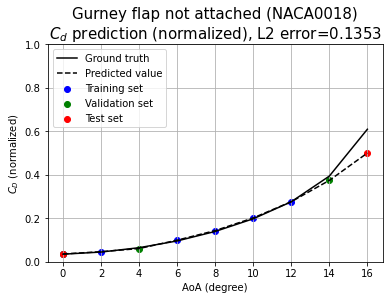

L2 error of Cd: 0.0166


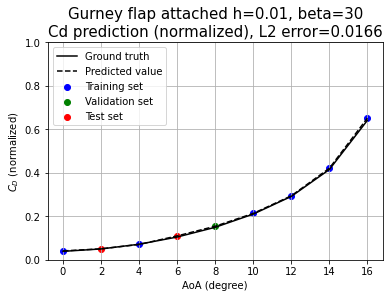

L2 error of Cd: 0.0117


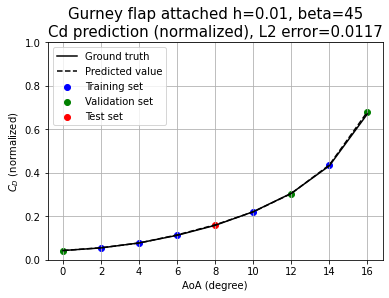

L2 error of Cd: 0.0161


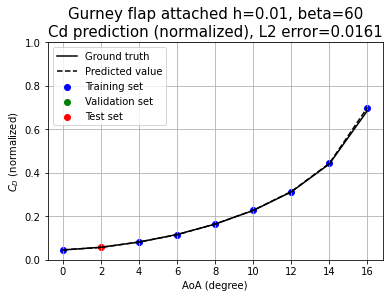

L2 error of Cd: 0.0357


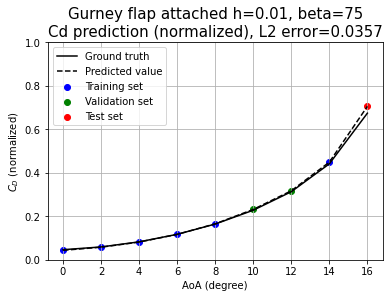

L2 error of Cd: 0.0173


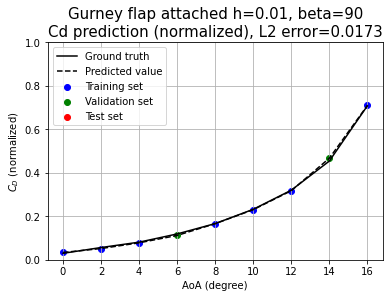

L2 error of Cd: 0.0183


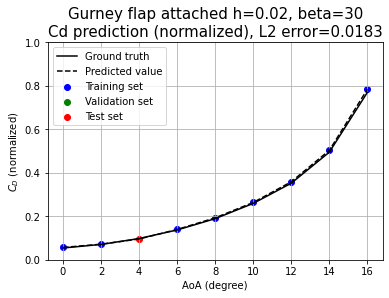

L2 error of Cd: 0.0207


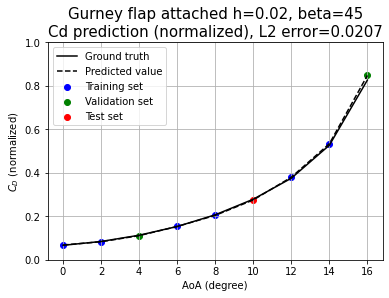

L2 error of Cd: 0.0153


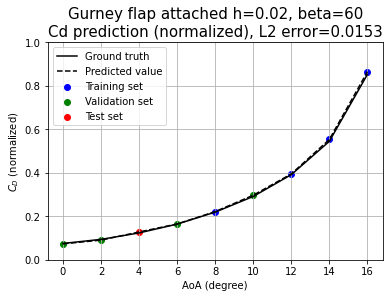

L2 error of Cd: 0.0181


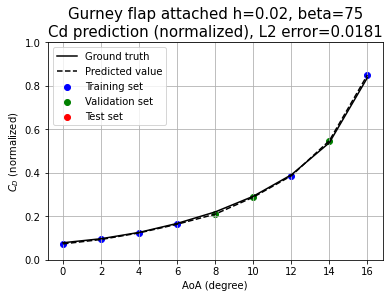

L2 error of Cd: 0.0304


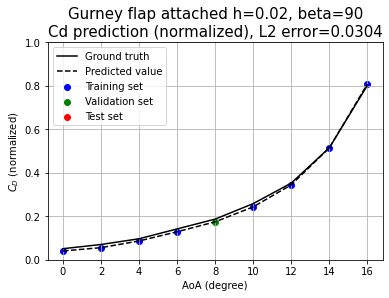

L2 error of Cd: 0.0196


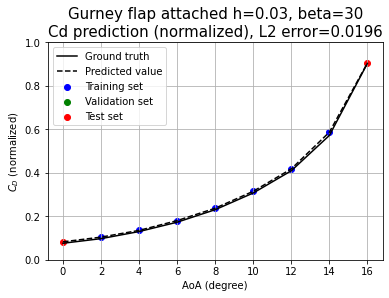

L2 error of Cd: 0.0171


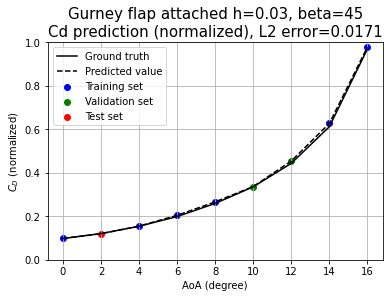

L2 error of Cd: 0.0231


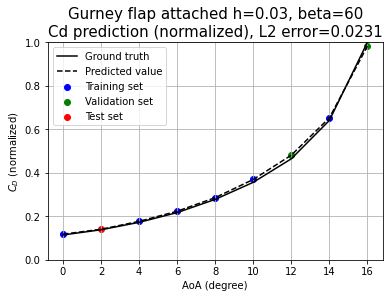

L2 error of Cd: 0.0151


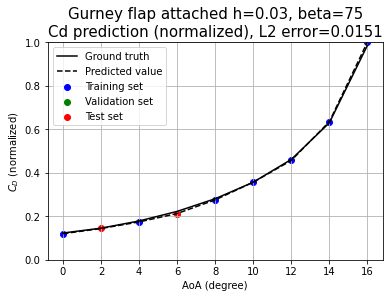

L2 error of Cd: 0.0812


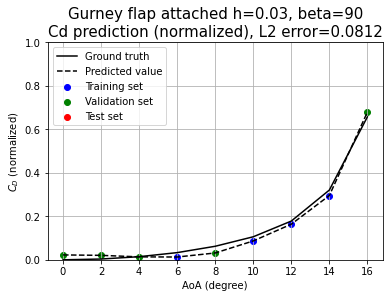

In [79]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]


for i in range(0, 16):
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    predictedValue = predicted[n_alpha*i:n_alpha*(i+1),:]
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    #l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cl))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1),:]
    #cd = predicted[n_alpha*i:n_alpha*(i+1),0]/10
    
    CD = y[n_alpha*i:n_alpha*(i+1),:]
    #CD = y[n_alpha*i:n_alpha*(i+1),0]/10
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest_.append(predicted[index])
        
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for ii, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)
    aVal = np.array(alpha_val)
    aTest = np.array(alpha_test)
    
    CL_trainTestSplit_Plot(i, CD, cd, aTrain, aVal, aTest, iTrain_, iVal_, iTest_)

In [80]:
iTrain_

array([[0.01279321],
       [0.08669402],
       [0.16372535],
       [0.29553223]], dtype=float32)

In [81]:
aa

array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
      